# Quickstart

***for Connectivity-based Hopfield Neural Networks (CHNNs)***

## Installation

```bash
pip install connattractor
```

- **Part 1**: The quickest way to plot and analyze your data on the CHNN projection
- **Part 2**: Build your own CHNN projection

**Imports**

In [8]:
import sys
sys.path.append('..')
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from connattractor import network, analysis


## Part 1: The quickest way to plot and analyze your data on the CHNN projection

For the quickest start, you can load the pre-computed embedding, calculated on the example connectome provided with the package.

In [2]:
with open('../data_out/default_hopfield_embedding_0.37.pkl', 'rb') as file:
    hopfield_embedding = pickle.load(file)

### Load the example task data, scrub it and seperate it into task and rest:

In [6]:
from sklearn.preprocessing import StandardScaler

_fd_thr = 0.15
_perc_scrub_thr = 0.5

rest = np.repeat(np.nan, 122)
task = np.repeat(np.nan, 122)
temperatures = [np.nan]
sub_rest = [np.nan]
sub_task = [np.nan]

_TR_ = 2.0 # seconds

for sub in range(1,33):
    sub_pad = f'{sub+1:02}'
    fd = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_FD.txt').values.flatten()
    fd = np.hstack(([0], fd))
    ts = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_ts.txt', sep='\t').iloc[:, 1:].values
    events = pd.read_csv('../data_in/ex_timeseries_task/sub-' + sub_pad + '_task-heatpainwithregulationandratings_run-01_events.tsv',
                        sep='\t')
    
    ts = StandardScaler().fit_transform(ts)

    if np.sum(fd>_fd_thr)/len(fd) < _perc_scrub_thr:
        ts[fd>=_fd_thr] = np.nan
    else:
        ts[:] = np.nan
        print('perc. scrubbed:', np.sum(fd>_fd_thr)/len(fd))
        
    # task timeframes: same duration, 6 sec delay in onset due to HRF
    # rest timeframes: starts 6 sec after last block, right until the onset of the next block
    
    rest_block = ts[0:(int(np.round(18+2/_TR_))), :]
    rest = np.vstack((rest, rest_block))
    sub_rest += [sub] * rest_block.shape[0]
    
    for i in events.index: 
        
        onset = int(np.round(events.loc[i, "onset"]/_TR_))
        end = onset + int(np.round(events.loc[i, "duration"]/_TR_))
        
        if not np.isnan(events.loc[i, "temperature"]):
            # early phase
            current_block = ts[(onset+int(np.round(8/_TR_))):(onset+int(np.round(16/_TR_))), :]
            task = np.vstack((task, current_block))
            temperatures += [events.loc[i, "temperature"]]*current_block.shape[0]
            sub_task += [sub] * current_block.shape[0]

temperatures = np.array(temperatures)[~np.ma.fix_invalid(task).mask.any(axis=1)]
sub_rest = np.array(sub_rest)[~np.ma.fix_invalid(rest).mask.any(axis=1)]
sub_task = np.array(sub_task)[~np.ma.fix_invalid(task).mask.any(axis=1)]
task = task[~np.ma.fix_invalid(task).mask.any(axis=1)]
rest = rest[~np.ma.fix_invalid(rest).mask.any(axis=1)]
rest.shape, task.shape, np.unique(temperatures), len(sub_rest)

perc. scrubbed: 0.8133971291866029
perc. scrubbed: 0.5741626794258373
perc. scrubbed: 0.6267942583732058
perc. scrubbed: 0.7081339712918661


((405, 122), (1052, 122), array([42.3, 43.3, 44.3, 45.3, 46. , 46.3]), 405)

### Plotting data in the projection plane

To get a good impression on the data in the projection, we first plot a contourplot of all activations of the rest data and plot the mean activations during rest of all study participants on the projection. We repeat the same for the task data.

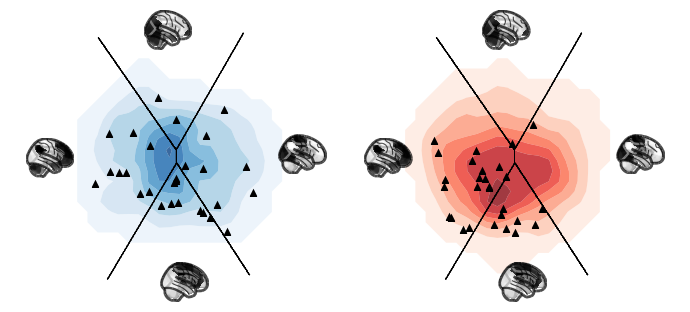

In [16]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(8, 4))
    
hopfield_embedding.plot(rest, plot_type='contourf', ax=ax[0],
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Blues',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

hopfield_embedding.plot(sub_means_rest, plot_type='scatter', ax=ax[0],
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )
ax[0].set_yticks([])
ax[0].grid(False)


hopfield_embedding.plot(task, plot_type='contourf', ax=ax[1],
                    density_bins=30, density_sigma=1, levels=6, alpha=0.8, cmap='Reds',
                    attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                    regimes_fill_kwargs=dict(alpha=0.0),
                    regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                   )

hopfield_embedding.plot(sub_means_task, plot_type='scatter', ax=ax[1],
                        marker='^', c='black', s=30,
                        attractor_plot_type='scatter', attractor_kwargs=dict(alpha=0),
                        regimes_fill_kwargs=dict(alpha=0.0),
                        regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                       )


    

ax[1].set_yticks([])
ax[1].grid(False)
plt.show()

### Statistical analysis

To compare the two conditions statistically with a permutation test, compare the position difference in the projection plane as well as the absolute energy difference as test statistics. In this example we calculate 1000 permutations, swapping the conditions and plot the actual difference against the null distribution.

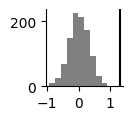

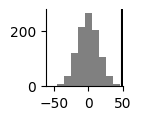

p(projection) = 0.0
p(energy) = 0.0


In [21]:
from numpy.linalg import norm
random = np.random.default_rng(42)
noise = 0.37
num_perm = 1000


sub_means_rest = np.array([np.mean(rest[sub_rest==sub], axis=0) for sub in np.unique(sub_rest)])
sub_means_task = np.array([np.mean(task[sub_task==sub], axis=0) for sub in np.unique(sub_task)])

task_embedded = hopfield_embedding.embedding_model.transform(sub_means_task)[:, :2]
rest_embedded = hopfield_embedding.embedding_model.transform(sub_means_rest)[:, :2]
diffs = task_embedded - rest_embedded
true_diffs_norm = np.array([norm(d) for d in diffs])
true_diff_mean = np.mean(true_diffs_norm)

energy_rest = np.array([hopfield_embedding.hopnet.energy(s) for s in sub_means_rest])
energy_task = np.array([hopfield_embedding.hopnet.energy(s) for s in sub_means_task])

true_energy_diff = energy_rest - energy_task
true_energy_diff_mean = np.mean(true_energy_diff)

n = len(diffs)
diffs = []
energy_diffs = []

for p in range(num_perm):
    # swap conditions randomly (i.e. sign flip)
    
    perm_i = random.choice([1,-1], n)
    diffs.append(np.mean(true_diffs_norm * perm_i))
    energy_diffs.append(np.mean(true_energy_diff * perm_i))


plt.figure(figsize=(1,1))
plt.hist(diffs, color='gray')
plt.axvline(true_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

plt.figure(figsize=(1,1))
plt.hist(energy_diffs, color='gray')
plt.axvline(true_energy_diff_mean, color='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()


print('p(projection) =', (diffs>true_diff_mean).sum()/num_perm)
print('p(energy) =', (energy_diffs>true_energy_diff_mean).sum()/num_perm)
    

## Part 2: Build your own CHNN projection

### Obtain functional connectivity matrix

Should be a partial correlation matrix, square and symmetric.

Below, we load in an example connectome, derived from study 1 of the manuscript.
Given the high replicability and generalizability of CHNN analyses, the connectome does not have to stem from the analyzed dataset. Similarly to anatomical standrad templates in neuroimaging practice, the supplied example connectome can be considered a standard connectome template.

Users are, nevertheless, encouraged to use dataset-specific connectomes.

#### Let's load in the example connectome

In [2]:
connfile = '../data_in/ex_connectome_partial_correlation.csv'
mtx = pd.read_csv(connfile).iloc[:, 1:]
mtx

,CER6_p,CER7ab,R_CERCR2_p,CER9_v,CER6_a,L_CERCR2_a,CER9_d,CER9_m,CER7b_m,L_CERCR2_p,...,LVISnet_vp,MVISnet_p,MVISnet_av,LVISnet_p,PVISnet_dm,PVISnet_vm,MVISnet_ad,VVISnet_l,LVISnet_DP,VVISnet_m
0,1.000000,0.023502,0.136701,0.008193,0.074264,0.021580,0.170827,0.028969,0.015883,0.130981,...,-0.002248,-0.008683,0.000152,0.035482,0.007705,-0.029055,0.009439,-0.001390,0.009582,0.007318
1,0.023502,1.000000,0.008167,0.024126,0.046648,0.050263,0.010915,0.070042,0.085829,-0.018248,...,0.033791,0.004000,0.011493,0.007582,-0.026080,0.008013,-0.009007,0.009144,0.001391,0.012831
2,0.136701,0.008167,1.000000,0.005056,0.062669,0.028488,0.041643,0.045169,0.112164,0.157129,...,-0.003300,0.016258,-0.011801,-0.001794,-0.000603,0.012350,-0.002757,-0.004949,-0.004858,-0.000633
3,0.008193,0.024126,0.005056,1.000000,-0.020494,-0.008721,-0.004522,0.203525,-0.003757,0.019182,...,0.021645,0.000472,-0.003774,0.003395,-0.032710,-0.015305,0.007360,0.004044,-0.011696,-0.001293
4,0.074264,0.046648,0.062669,-0.020494,1.000000,0.080293,0.024584,0.002491,-0.021720,0.042291,...,-0.020753,0.005295,-0.012844,-0.014833,0.009989,0.024167,-0.005186,-0.016061,0.010920,-0.007650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,-0.029055,0.008013,0.012350,-0.015305,0.024167,-0.007512,0.045950,0.010056,-0.006412,-0.000421,...,0.011186,0.215436,-0.011083,-0.003814,0.163692,1.000000,0.013773,0.049101,-0.028493,0.115196
118,0.009439,-0.009007,-0.002757,0.007360,-0.005186,-0.023476,-0.004195,-0.029927,-0.023948,-0.023841,...,-0.012657,0.258308,0.091981,0.007686,-0.001867,0.013773,1.000000,-0.013407,0.017465,0.032366
119,-0.001390,0.009144,-0.004949,0.004044,-0.016061,0.004057,0.002311,-0.022643,0.001888,-0.007811,...,0.139682,-0.014010,0.077810,0.079338,0.055300,0.049101,-0.013407,1.000000,0.081084,0.162297
120,0.009582,0.001391,-0.004858,-0.011696,0.010920,0.002928,-0.001322,0.004114,-0.006720,-0.008002,...,0.066451,0.001324,-0.001214,0.115287,0.089609,-0.028493,0.017465,0.081084,1.000000,0.000165


#### Now we construct a CHNN and plot the weights

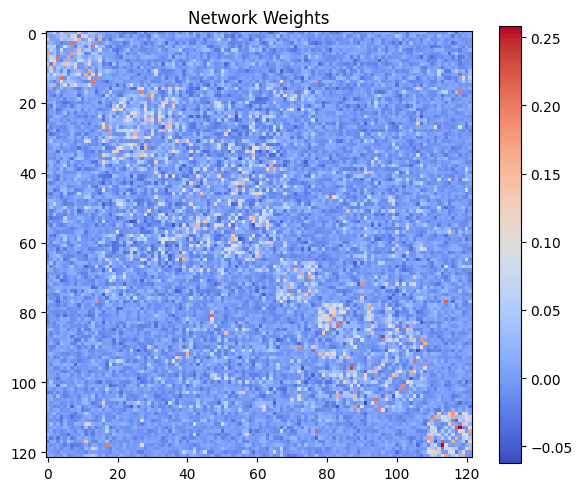

In [3]:
hopnet = network.Hopfield(mtx)
hopnet.plot_weights()

#### Now we run the stochastic relaxation procedure to obtain simulated states
It may take a few seconds...

In [4]:
chnn_state_space = analysis.simulate_activations(mtx.values,
                                            noise_coef=0.37,
                                            num_iter=100000,
                                            beta=0.04,
                                            random_state=42)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4619.54it/s]


#### We create a Hopfield Embedding
Again, a few seconds...

In [5]:
chnn_projection = analysis.create_embeddings(chnn_state_space,
                                             attractor_sample=1000,
                                             random_state=42)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:59<00:00, 16.92it/s]


#### and plot the state space in it

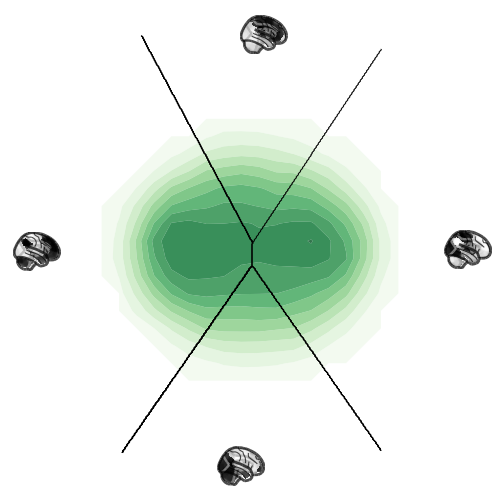

In [6]:
ax = chnn_projection.plot(chnn_state_space.states, plot_type='contourf',
                          density_bins=30, density_sigma=0.5, levels=12, alpha=0.8, cmap='Greens',
                          attractor_plot_type='glassbrain', attractor_kwargs=dict(cmap='binary'),
                          regimes_fill_kwargs=dict(alpha=0.0),
                          regimes_contour_kwargs=dict(alpha=1.0, colors='black')
                         )
ax.set_yticks([])
ax.grid(False)